In [1]:
import scanpy as sc
import squidpy as sq
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from matplotlib_scalebar.scalebar import ScaleBar
import os

import cell2location
import scvi

DPI = 300
FONTSIZE = 20  # 42
sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

from matplotlib import rcParams
import seaborn as sns
from pathlib import Path

# QC utils functions - a package
from vistools import utils
from vistools import spatial_plots

Global seed set to 0


## Prepare inputs for cell2location or any downstream analysis
* creating a single andata object containing multiple spatial samples. These samples have been QC already.

In [2]:
# list of samples (names) to process
VIS_SAMPLE_LIST = [("CRC08_LM_VISIUM", "/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC08_LM_VISIUM/CRC08_LM_VISIUM_raw.h5ad"), 
                   ("CRC09_LM_VISIUM", "/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC09_LM_VISIUM/CRC09_LM_VISIUM_raw_removal_spots.h5ad"), 
                   ("CRC11_LM_VISIUM", "/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC11_LM_VISIUM/CRC11_LM_VISIUM_raw.h5ad"),
                   ("Wu2022_ST_LM1", "/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/Wu2022_ST_LM1/Wu2022_ST_LM1_raw.h5ad"),
                   ("Wu2022_ST_LM2", "/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/Wu2022_ST_LM2/Wu2022_ST_LM2_raw.h5ad"),
                   ("Wu2022_ST_LM4", "/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/Wu2022_ST_LM4/Wu2022_ST_LM4_raw.h5ad")
                  ]
# before for CRC09 /data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC09_LM_VISIUM/CRC09_LM_VISIUM_raw.h5ad

In [3]:
# DIR2SAVE
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/concat_withWu2022/"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [4]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [5]:
VIS_SAMPLE_LIST

[('CRC08_LM_VISIUM',
  '/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC08_LM_VISIUM/CRC08_LM_VISIUM_raw.h5ad'),
 ('CRC09_LM_VISIUM',
  '/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC09_LM_VISIUM/CRC09_LM_VISIUM_raw_removal_spots.h5ad'),
 ('CRC11_LM_VISIUM',
  '/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC11_LM_VISIUM/CRC11_LM_VISIUM_raw.h5ad'),
 ('Wu2022_ST_LM1',
  '/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/Wu2022_ST_LM1/Wu2022_ST_LM1_raw.h5ad'),
 ('Wu2022_ST_LM2',
  '/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/Wu2022_ST_LM2/Wu2022_ST_LM2_raw.h5ad'),
 ('Wu2022_ST_LM4',
  '/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/Wu2022_ST_LM4/Wu2022_ST_LM4_raw.h5ad')]

In [6]:
[ele[0] for ele in VIS_SAMPLE_LIST]

['CRC08_LM_VISIUM',
 'CRC09_LM_VISIUM',
 'CRC11_LM_VISIUM',
 'Wu2022_ST_LM1',
 'Wu2022_ST_LM2',
 'Wu2022_ST_LM4']

### Load adatas that have already undergone qc: nb genes, nb counts, find mt, ribo genes

In [7]:
# load adatas that have already undergone qc: nb genes, nb counts, find mt, ribo genes

# read first sample
print(f"Loading sample {VIS_SAMPLE_LIST[0][0]}")
print(f"Path {VIS_SAMPLE_LIST[0][1]}")
adata = sc.read_h5ad(
    VIS_SAMPLE_LIST[0][1] # read 1st visium sample
)

# read the remaining samples
slides = (
    {}
)  # dictionary that will contain spatial adata, with light pre-processing done
for i in VIS_SAMPLE_LIST[1:]:
    print(f"Loading sample {i[0]}")
    print(f"Path {i[1]}")
    adata_1 = sc.read_h5ad(i[1])
    slides[str(i[0])] = adata_1

adata_0 = adata.copy()

# combine individual samples
# adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="Sample_name",
    uns_merge="unique",
    batch_categories=[ele[0] for ele in VIS_SAMPLE_LIST],
    index_unique=None,
    join="inner"
    # join='outer'
)

slides[VIS_SAMPLE_LIST[0][0]] = adata_0

Loading sample CRC08_LM_VISIUM
Path /data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC08_LM_VISIUM/CRC08_LM_VISIUM_raw.h5ad
Loading sample CRC09_LM_VISIUM
Path /data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC09_LM_VISIUM/CRC09_LM_VISIUM_raw_removal_spots.h5ad
Loading sample CRC11_LM_VISIUM
Path /data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/CRC11_LM_VISIUM/CRC11_LM_VISIUM_raw.h5ad
Loading sample Wu2022_ST_LM1
Path /data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/Wu2022_ST_LM1/Wu2022_ST_LM1_raw.h5ad
Loading sample Wu2022_ST_LM2
Path /data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/Wu2022_ST_LM2/Wu2022_ST_LM2_raw.h5ad
Loading sample Wu2022_ST_LM4
Path /data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/Wu2022_ST_LM4/Wu2022_ST_LM4_raw.h5ad


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [8]:
slides

{'CRC09_LM_VISIUM': AnnData object with n_obs × n_vars = 937 × 20471
     obs: 'in_tissue', 'array_row', 'array_col', 'Sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
     uns: 'Sample_colors', 'spatial'
     obsm: 'mt', 'ribo', 'segmentation_features', 'spatial',
 'CRC11_LM_VISIUM': AnnData object with n_obs × n_vars = 1774 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'Sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
   

In [9]:
adata.shape

(16108, 16451)

In [10]:
sc.pp.filter_cells(adata, min_genes=5)
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
adata.shape

(16108, 16451)

Here we do an **inner join** for the concat, so selects only the intersection of genes which gives 16367 genes. If we did an outer join we would have 21977 genes.

So we lose: 1-16367/21977, roughly 25%

In [12]:
adata

AnnData object with n_obs × n_vars = 16108 × 16451
    obs: 'in_tissue', 'array_row', 'array_col', 'Sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'Sample_source', 'Sample_name'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts-CRC08_LM_VISIUM', 'mean_counts-CRC08_LM_VISIUM', 'pct_dropout_by_counts-CRC08_LM_VISIUM', 'total_counts-CRC08_LM_VISIUM', 'n_cells-CRC08_LM_VISIUM', 'n_cells_by_counts-CRC09_LM_VISIUM', 'mean_counts-CRC09_LM_VISIUM', 'pct_dropout_by_counts-CRC09_LM_VISIUM', 'total_counts-CRC09_LM_VISIUM', 'n_cells-CRC09_LM_VISIUM', 'n_cells_by_counts-CRC11_LM_VISIUM', 'mean_counts-CRC11_LM_VISIUM', 'pct_dropout_by_counts-CRC11_LM_VISIUM', 'total_counts-CRC11_LM_VISIUM', 'n_cells-CRC11_LM_VISIUM', 'n_cells_by_counts-Wu2022_ST_LM1', 'mean_counts

In [13]:
adata.uns["spatial"].keys()

dict_keys(['CRC08_LM_VISIUM', 'CRC09_LM_VISIUM', 'CRC11_LM_VISIUM', 'P13_Liver_ST', 'P3_liver', 'ST_LM_4'])

In [14]:
adata.obs

,in_tissue,array_row,array_col,Sample,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,Sample_source,Sample_name
spot_id,,,,,,,,,,,,,,,,,
CRC08_LM_VISIUM_AAACAAGTATCTCCCA-1,1,50,102,CRC08_LM_VISIUM,7893,52062.0,30.025739,42.820099,51.646114,61.620760,3657.0,7.024317,15750.0,30.252392,7688,NaN,CRC08_LM_VISIUM
CRC08_LM_VISIUM_AAACCGGAAATGTTAA-1,1,54,124,CRC08_LM_VISIUM,3237,10090.0,33.092170,44.400396,53.468781,65.153617,1340.0,13.280476,2507.0,24.846382,3115,NaN,CRC08_LM_VISIUM
CRC08_LM_VISIUM_AAACCGTTCGTCCAGG-1,1,52,42,CRC08_LM_VISIUM,5291,20951.0,29.282612,39.563744,48.837764,60.097370,2714.0,12.954036,4263.0,20.347477,5143,NaN,CRC08_LM_VISIUM
CRC08_LM_VISIUM_AAACCTAAGCAGCCGG-1,1,65,83,CRC08_LM_VISIUM,7908,54068.0,24.297181,35.795665,46.572834,59.108900,829.0,1.533254,13208.0,24.428497,7706,NaN,CRC08_LM_VISIUM
CRC08_LM_VISIUM_AAACGAGACGGTTGAT-1,1,35,79,CRC08_LM_VISIUM,1959,5701.0,38.537099,50.798106,59.936853,72.408349,817.0,14.330819,1733.0,30.398174,1858,NaN,CRC08_LM_VISIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST_LM_4_TTGTTGTGTGTCAAGA-1,1,31,77,ST_LM_4,2043,4088.0,22.529354,33.023483,43.713307,60.420744,49.0,1.198630,897.0,21.942270,1930,Wu2022_ST_LM4-ST_LM_4,Wu2022_ST_LM4
ST_LM_4_TTGTTTCACATCCAGG-1,1,58,42,ST_LM_4,681,1215.0,37.201646,47.818930,60.411523,85.102881,65.0,5.349794,112.0,9.218107,578,Wu2022_ST_LM4-ST_LM_4,Wu2022_ST_LM4
ST_LM_4_TTGTTTCATTAGTCTA-1,1,60,30,ST_LM_4,917,1922.0,40.218522,49.687825,60.770031,78.303850,57.0,2.965661,130.0,6.763788,790,Wu2022_ST_LM4-ST_LM_4,Wu2022_ST_LM4


In [15]:
slides

{'CRC09_LM_VISIUM': AnnData object with n_obs × n_vars = 937 × 20471
     obs: 'in_tissue', 'array_row', 'array_col', 'Sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
     uns: 'Sample_colors', 'spatial'
     obsm: 'mt', 'ribo', 'segmentation_features', 'spatial',
 'CRC11_LM_VISIUM': AnnData object with n_obs × n_vars = 1774 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'Sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
   

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


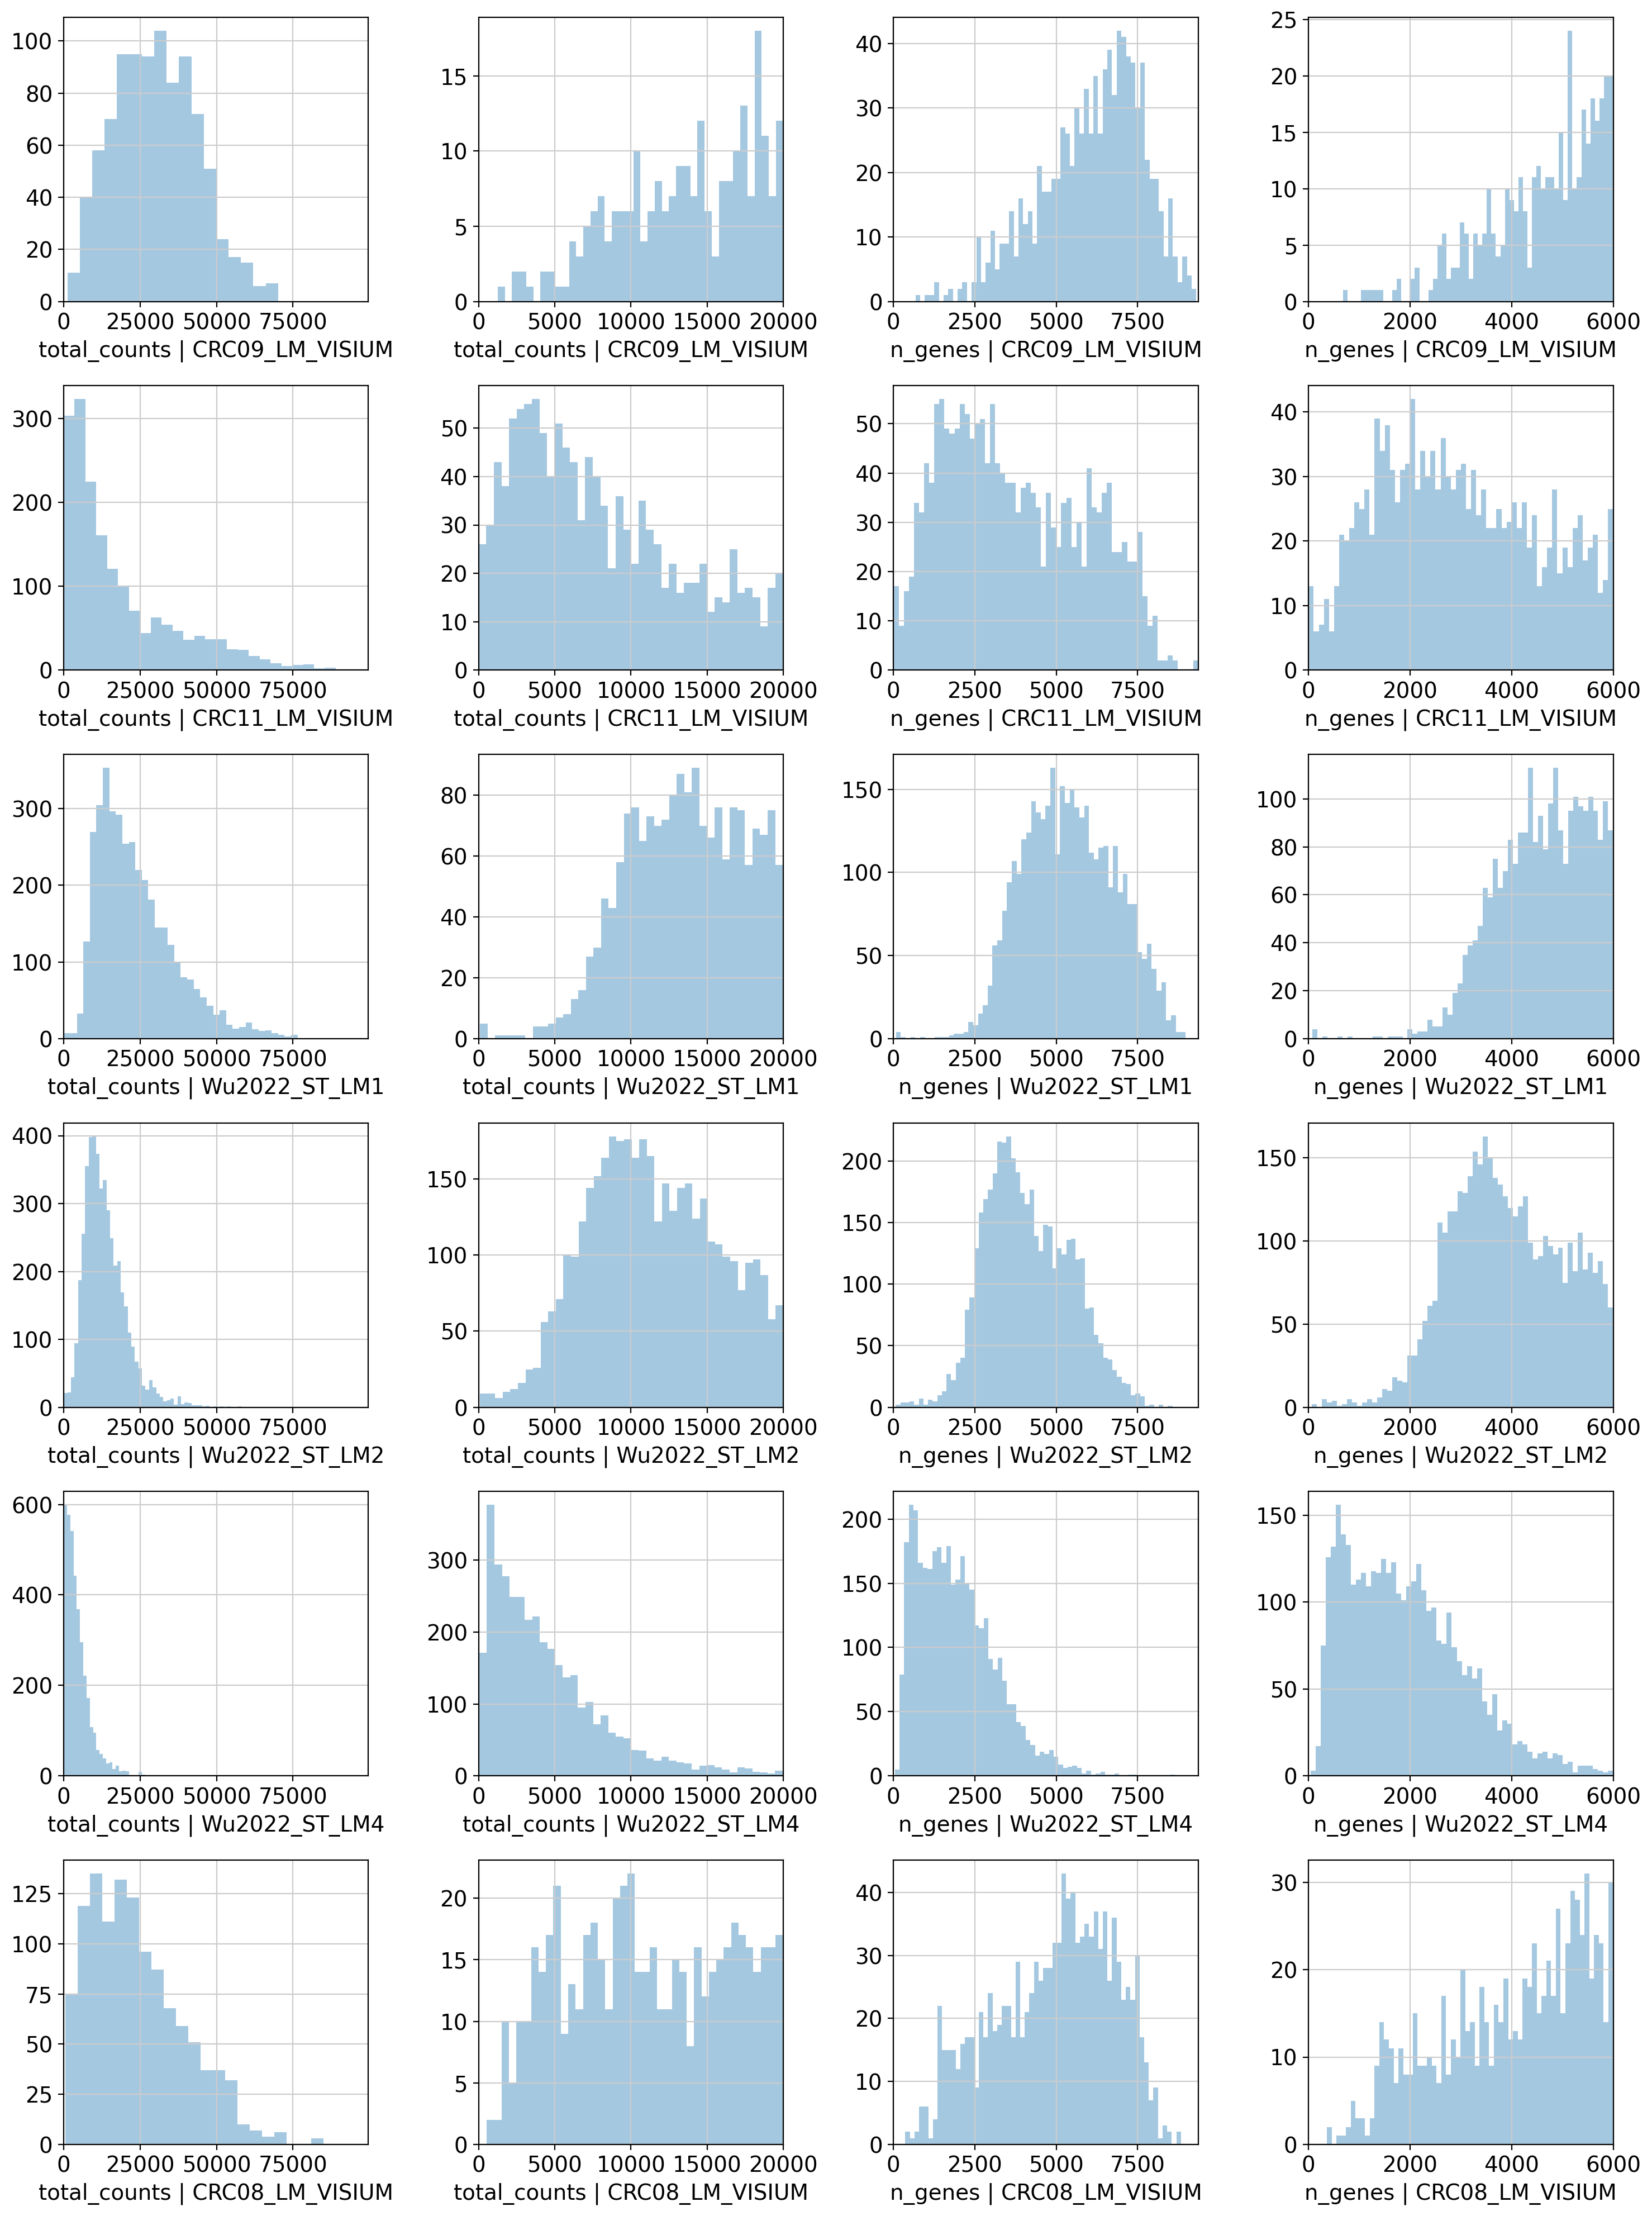

In [16]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4 * len(slides) - 4))
for i in range(len(slides)):
    # fig.suptitle('Covariates for filtering')

    sns.distplot(list(slides.values())[i].obs["total_counts"], kde=False, ax=axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs["total_counts"].max())
    axs[i, 0].set_xlabel("total_counts | " + list(slides.keys())[i])

    sns.distplot(
        list(slides.values())[i].obs["total_counts"][
            list(slides.values())[i].obs["total_counts"] < 20000
        ],
        kde=False,
        bins=40,
        ax=axs[i, 1],
    )
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel("total_counts | " + list(slides.keys())[i])

    sns.distplot(
        list(slides.values())[i].obs["n_genes_by_counts"],
        kde=False,
        bins=60,
        ax=axs[i, 2],
    )
    axs[i, 2].set_xlim(0, adata.obs["n_genes_by_counts"].max())
    axs[i, 2].set_xlabel("n_genes | " + list(slides.keys())[i])

    sns.distplot(
        list(slides.values())[i].obs["n_genes_by_counts"][
            list(slides.values())[i].obs["n_genes_by_counts"] < 6000
        ],
        kde=False,
        bins=60,
        ax=axs[i, 3],
    )
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel("n_genes | " + list(slides.keys())[i])

plt.tight_layout()
plt.savefig(
    FIG2SAVE.joinpath("hist_QC_covariates.pdf"),
    dpi=DPI,
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [17]:
adata.obs.describe()

,in_tissue,array_row,array_col,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
count,16108.0,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000,16108.000000
mean,1.0,39.293953,62.611435,4060.314130,16232.999023,27.844955,38.068596,48.494302,62.729704,755.622131,4.505416,3441.747314,18.460243,3880.453377
std,0.0,17.947125,33.912608,1986.348282,13542.121094,7.208379,7.473758,7.863267,9.711793,957.102051,3.391637,4040.111572,7.525882,1950.359011
min,1.0,0.000000,0.000000,5.000000,5.000000,14.069758,21.242422,29.642098,42.576187,0.000000,0.000000,0.000000,0.000000,5.000000
25%,1.0,26.000000,35.000000,2585.000000,6372.750000,22.387597,32.557650,43.137698,56.923486,133.000000,1.876866,943.000000,11.430448,2421.500000
50%,1.0,40.000000,63.000000,4014.000000,12660.500000,26.914305,37.739527,48.102577,61.385098,395.000000,3.982685,1928.500000,18.563383,3820.500000
75%,1.0,53.000000,90.000000,5564.000000,22046.750000,32.313857,43.008482,53.450105,66.486074,1023.000000,6.134937,4295.250000,23.839016,5359.000000
max,1.0,77.000000,127.000000,9359.000000,99644.000000,100.000000,100.000000,100.000000,100.000000,12204.000000,55.163509,37404.000000,45.328148,9113.000000


In [18]:
adata.obs.Sample_name.cat.categories

Index(['CRC08_LM_VISIUM', 'CRC09_LM_VISIUM', 'CRC11_LM_VISIUM',
       'Wu2022_ST_LM1', 'Wu2022_ST_LM2', 'Wu2022_ST_LM4'],
      dtype='object')

In [19]:
adata.uns["Sample_name_colors"] = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f"]

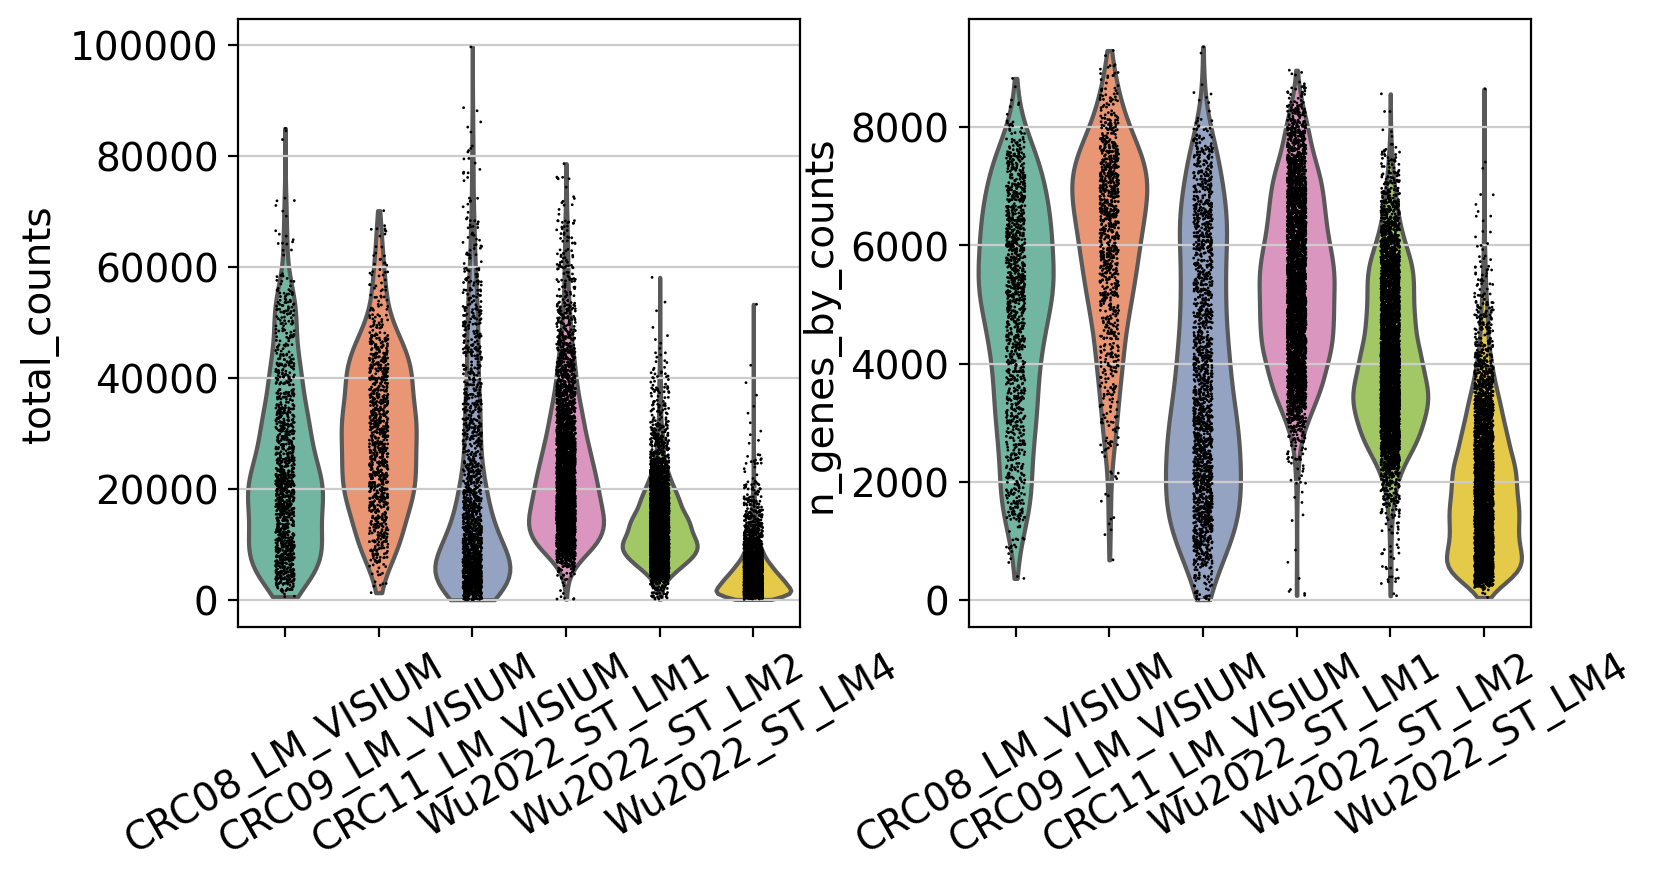

In [20]:
sc.pl.violin(
    adata,
    keys=["total_counts", "n_genes_by_counts"],
    groupby="Sample_name",
    multi_panel=True,
    rotation=30,
    jitter=0.1,
    save="QC_sample.pdf",
)

### write to file

In [21]:
DIR2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/concat_withWu2022')

In [22]:
adata.write(DIR2SAVE.joinpath("concat_withWu2022_raw.h5ad"))

In [23]:
adata = sc.read_h5ad(DIR2SAVE.joinpath("concat_withWu2022_raw.h5ad"))